# ORIE 5530 Project: NYC Citibike

- Pietro Perrone, pp487@cornell.edu
- Brendan Woodward, bvw3@cornell.edu
- Dulat Amangeldiyev, da449@cornell.edu

In New York City, CitiBike is a popular way for people to get around. These bikes can be found at stations all over the city and anyone can use them. However, there's a big question: how many bikes are available at a station at any given time? This is important for people who want to use the bikes and for those who run the system.

Our project methodology was about figuring out how many bikes are available at certain busy CitiBike stations, especially during the morning and evening on weekdays. We used "Discrete Markov Chains" to make our predictions, which will help us understand how bikes are used throughout the day.

After basic popularity analysis, We picked these three CitiBike stations:
- Broadway & W 58 St, 11097 (st. id: 6948.10), which is located near the Central Park.
- West St & Liberty St, 9752 (st. id: 5184.08), which is loacted in the Fiancial District, specifically near the 9/11 Memorial site.
- Pier 40 - Hudson River Park, 8995 (st. id: 5696.03), located along the river at the piers, in this case Pier 40, just west of SoHo.

We looked closely at how many bikes are there in the morning and in the evening and broke down these times into small period of 10 minutes, to really understand what's going on at a certain given time. All the details of our analysis is described below along with the code.

By doing this project, we want to help people know more about bike availability. This can make it easier for them to use CitiBike. It can also help the people who manage these bikes to make sure there are enough bikes for everyone who wants to use them. This project is not just about bikes; it's about making the city a better place for everyone.

Here below, the first part of the project, warm-up questions:

# Warm-up

0. This is a preprocessing stage, where we loading, cleaning and filtering the data that we need. Steps done in this stage:
- loading and reading the CSV file
- converting start and end time into readable format
- dropping N/A values to make analysis easier
- calculating duration of trips in minutes
- removing rides more than 3 hours, and also any invalid raides where duration is less than 0

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import scipy as sp
import math
warnings.filterwarnings('ignore')

In [3]:
df_citibike = pd.read_csv("202307-citibike-tripdata.csv")

In [4]:
df_citibike.started_at = pd.to_datetime(df_citibike.started_at)
df_citibike.ended_at = pd.to_datetime(df_citibike.ended_at)

In [5]:
df_citibike.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,BC78328130CD8A16,classic_bike,2023-07-16 20:42:57,2023-07-16 20:45:13,St. Nicholas Ave & W 126 St,7756.10,Adam Clayton Powell Blvd & W 126 St,7738.04,40.811432,-73.951878,40.809495,-73.947765,member
1,71A4DFA231ADAEA2,classic_bike,2023-07-29 12:22:21,2023-07-29 12:26:54,Adam Clayton Powell Blvd & W 118 St,7670.09,Adam Clayton Powell Blvd & W 126 St,7738.04,40.804372,-73.951475,40.809495,-73.947765,member
2,B64451D0D9F52134,classic_bike,2023-07-30 18:30:18,2023-07-30 18:35:42,St. Nicholas Ave & W 126 St,7756.10,Lenox Ave & W 130 St,7753.13,40.811378,-73.951827,40.810792,-73.943068,member
3,EEECB3E0E05EB0DB,classic_bike,2023-07-04 19:59:20,2023-07-04 20:02:03,St. Nicholas Ave & W 126 St,7756.10,Adam Clayton Powell Blvd & W 126 St,7738.04,40.811432,-73.951878,40.809495,-73.947765,member
4,76B706DF4FC180DC,classic_bike,2023-07-03 19:33:36,2023-07-03 19:43:59,St. Nicholas Ave & W 126 St,7756.10,Pleasant Ave & E 116 St,7450.05,40.811543,-73.951813,40.794988,-73.933335,member


In [6]:
df_citibike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3776256 entries, 0 to 3776255
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
dtypes: datetime64[ns](2), float64(4), object(7)
memory usage: 374.5+ MB


In [13]:
# Dropping N/A values to make analysis easier
df_citibike = df_citibike.dropna()

In [15]:
# Calculating duration of trips in minutes
df_citibike["duration"] = (df_citibike.ended_at - df_citibike.started_at).dt.total_seconds() / 60
df_citibike.duration

0           2.266667
1           4.550000
2           5.400000
3           2.716667
4          10.383333
             ...    
3776251    26.650000
3776252    28.316667
3776253     4.450000
3776254    10.683333
3776255     2.566667
Name: duration, Length: 3760004, dtype: float64

In [17]:
# Removing rides more than 3 hours, and also any invalid raides where duration is less than 0
df_citibike = df_citibike[df_citibike.duration <= 60*3]
df_citibike = df_citibike[df_citibike.duration > 0]

## 1. Using the start time and end time, compute the duration of each ride in minutes and plot the histogram of ride durations.

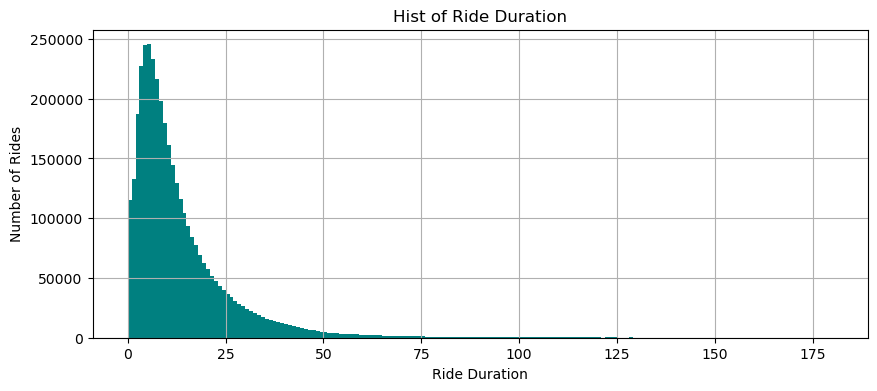

In [18]:
# Plotting the histogram of Ride Duration
plt.figure(figsize=(10,4))
plt.hist(df_citibike.duration, bins=3*60, color = 'teal')
plt.title("Hist of Ride Duration")
plt.xlabel("Ride Duration")
plt.ylabel("Number of Rides")
plt.grid()
plt.show()

**Analysis:**

The histogram is skewed to the right, meaning there are a higher number of shorter rides compared to longer ones. Most rides last less than 25 minutes, with the frequency dramatically decreasing as the ride duration increases. There is a significant drop after the 5-minute mark, which could indicate that very short rides are quite common.

The bulk of rides are concentrated in the lower duration bins, suggesting that users prefer quick trips. The frequency of rides continues to taper off as the duration extends beyond 25 minutes, with very few rides lasting longer than 75 minutes. The longest durations plotted on the histogram seem to be around 175 minutes, but these occurrences are rare.

## 2. What is the expected ride duration (i.e., the average ride duration)? What is the empirical variance of ride duration? What is the probability that a ride duration is greater than 20 min?

In [19]:
total = len(df_citibike)

In [20]:
avg_dur = df_citibike.duration.mean()
print(f"Average Duration = {avg_dur}")

Average Duration = 13.560309878216444


In [21]:
var_dur = df_citibike.duration.var()
print(f"Variance of Duration = {var_dur}")

Variance of Duration = 196.712993415748


In [24]:
gt_20 = (df_citibike.duration > 20).sum()
p_dur_20 = gt_20 / total
print(f"Probability of ride duration being greater than 20 min is -> P(duration > 20) = {p_dur_20}")

Probability of ride duration being greater than 20 min is -> P(duration > 20) = 0.19654128027523374


**Analysis:**

As indicated by the histogram, rides lasting longer than 20 minutes are relatively rare, constituting only 20% of the total rides in the city.

## 3. What is the probability that a ride duration is greater than 20 min conditioning on the fact that the user is a CitiBike member? This is precisely: $\mathbb{P}$(Duration > 20 | CitiBike Member).

Note that the last column gives whether the ride is for a casual client or a CitiBike member.

We model this question in this probability form by applying Bayes rule: $\mathbb{P}$ (Duration > 20 and CitiBike Member) / $\mathbb{P}$(CitiBike Member)

In [28]:
p_citibike_mem = (df_citibike.member_casual == "member").sum() / total
p_cbmem_and_dur20 = ((df_citibike.member_casual == "member") & (df_citibike.duration > 20)).sum() / total
p_dur20_given_citibike_mem = p_cbmem_and_dur20 / p_citibike_mem
print(f"P(duration > 20 | CitiBike Member) = {p_dur20_given_citibike_mem}")

P(duration > 20 | CitiBike Member) = 0.15468512253344552


**Analysis:**

Rides exceeding 20 minutes are relatively infrequent even for CitiBike members, comprising about 15.47% of their total rides.

## 4. Suppose that the duration of some ride is more than 25min. What is the probability that this ride belongs to a CitiBike member? This is precisely: $\mathbb{P}$(CitiBike Member | Duration > 25).

We model this question in this probability form by applying Bayes rule: $\mathbb{P}$(Duration > 25 and CitiBike Member) / $ \mathbb{P}$(Duration > 25)

In [30]:
p_dur_25 = (df_citibike.duration > 25).sum() / total
p_cbmem_and_dur25 = ((df_citibike.member_casual == "member") & (df_citibike.duration > 25)).sum() / total
p_dur25_given_citibike_mem = p_cbmem_and_dur25 / p_dur_25
print(f"P(CitiBike Member | duration > 25) = {p_dur25_given_citibike_mem}")

P(CitiBike Member | duration > 25) = 0.5787193520578978


**Analysis:**

When a ride lasts longer than 25 minutes, there is a 57.87% probability that the rider is a CitiBike member.

## 5. What is the expected ride duration of an electric bike? What is the expected ride duration of a classic bike?

In [31]:
df_elecbike = df_citibike[df_citibike.rideable_type == "electric_bike"]
df_clasbike = df_citibike[df_citibike.rideable_type == "classic_bike"]

In [32]:
avg_dur_eb = df_elecbike.duration.mean()
avg_dur_cb = df_clasbike.duration.mean()
print(f"Expected Duration: e-bike={avg_dur_eb} ; classic bike={avg_dur_cb}")

Expected Duration: e-bike=12.280488130239785 ; classic bike=13.634854334405624


**Analysis:**

Nevertheless the fact that there is no big difference, E-bikes show a shorter expected ride duration at about 12.28 minutes, indicating a preference for quicker, more efficient trips. Classic bikes have a slightly longer average duration of 13.63 minutes, suggesting they are chosen for less hurried journeys or when e-bikes are not available.

## 6. Suppose that the duration of some ride is less than 10min. What is the probability that this ride uses an electric bike? What is the probability that this ride uses a classic bike? Comment on the results.

We model this question in this probability form by applying Bayes rule: 
- $\mathbb{P}$(Electric Bike | Duration < 10) $= \mathbb{P}$(Electric Bike and Duration < 10) / $ \mathbb{P}$(Duration < 10), 
- $\mathbb{P}$(Classic Bike | Duration < 10) $= \mathbb{P}$(Classic Bike and Duration < 10) $/ \mathbb{P}$(Duration < 10)

In [34]:
p_d10 = (df_citibike.duration < 10).sum() / total
p_eb_and_d10 = ((df_citibike.rideable_type == "electric_bike") & (df_citibike.duration < 10)).sum() / total
p_cb_and_d10 = ((df_citibike.rideable_type == "classic_bike") & (df_citibike.duration < 10)).sum() / total
p_eb_given_d10 = p_eb_and_d10 / p_d10
p_cb_given_d10 = p_cb_and_d10 / p_d10
print(f"P(E-bike | duration < 10)={p_eb_given_d10}\nP(classic-bike | duration < 10)={p_cb_given_d10}")

P(E-bike | duration < 10)=0.08921668362156664
P(classic-bike | duration < 10)=0.9101774950274062


**Analysis:**

For rides shorter than 10 minutes, there is an 8.92% probability that the chosen bike is an e-bike, while there is a 91.02% probability that it is a classic bike. This suggests a strong preference for classic bikes for shorter trips and e-bikes are preferred for longer and energy consuming trips.

# Project Portion: Estimation of the number of available bikes in the selected station 

**Station selection:**

To choose a station, we identified the busiest stations in terms of both trip origins and destinations.

We made our picks by looking at **how often rides occurred** and **how well-known the locations** were.

The following are the findings:

In [37]:
df_start = df_citibike.groupby(["start_station_id", "start_station_name"]).ride_id.count().sort_values(ascending=False)

In [38]:
df_start.head(25)

start_station_id  start_station_name         
6140.05           W 21 St & 6 Ave                12453
5329.03           West St & Chambers St          12361
6948.10           Broadway & W 58 St             11097
6726.01           11 Ave & W 41 St               10559
6364.07           6 Ave & W 33 St                10130
6765.01           12 Ave & W 40 St               10015
6157.04           10 Ave & W 14 St                9999
5184.08           West St & Liberty St            9752
5905.14           University Pl & E 14 St         9682
6912.01           7 Ave & Central Park South      9656
6822.09           1 Ave & E 68 St                 9631
5980.07           E 17 St & Broadway              9308
6173.08           Broadway & W 25 St              8960
6459.07           W 30 St & 10 Ave                8929
5696.03           Pier 40 - Hudson River Park     8904
5905.12           Broadway & E 14 St              8686
5492.05           Cleveland Pl & Spring St        8682
6331.01           W

In [39]:
df_end = df_citibike.groupby(["end_station_id", "end_station_name"]).ride_id.count().sort_values(ascending=False)

In [40]:
df_end.head(25)

end_station_id  end_station_name           
6140.05         W 21 St & 6 Ave                13658
6948.10         Broadway & W 58 St             12028
6726.01         11 Ave & W 41 St               11967
6912.01         7 Ave & Central Park South     11391
6364.07         6 Ave & W 33 St                11091
6765.01         12 Ave & W 40 St               10899
5905.14         University Pl & E 14 St        10548
6822.09         1 Ave & E 68 St                10403
5980.07         E 17 St & Broadway             10242
6459.07         W 30 St & 10 Ave               10003
5905.12         Broadway & E 14 St              9642
5492.05         Cleveland Pl & Spring St        9588
6331.01         W 31 St & 7 Ave                 9576
6197.08         E 33 St & 1 Ave                 9527
6535.04         W 34 St & Hudson Blvd E         9090
6450.12         8 Ave & W 33 St                 9079
5696.03         Pier 40 - Hudson River Park     8995
5788.13         Lafayette St & E 8 St           8929
64

As a result of sorted station activity data above, we decided to select these stations:
- **6948.10, Broadway & W 58 St, 11097**
    - Near Central Park
- **5184.08, West St & Liberty St, 9752**
    - In Financial District (near 9/11 Memorial)
- **5696.03, Pier 40 - Hudson River Park, 8995**
    - At piers by water (this one at Pier 40, west of SoHo)

In [42]:
# Creating a dictonary of stations for future usages
station_1_id = "6948.10"
station_2_id = "5184.08"
station_3_id = "5696.03"
station_ids = [station_1_id, station_2_id, station_3_id]
station_map = {
    '6948.10': {
        "station_name": 'Broadway & W 58 St', 
        "dock_size": 53
    },
    '5184.08': {
        "station_name": 'West St & Liberty St', 
        "dock_size": 34
    },
    '5696.03': {
        "station_name": 'Pier 40 - Hudson River Park', 
        "dock_size": 19
    },
}

In [43]:
mask_st = df_citibike.start_station_id.isin(station_ids)
mask_end = df_citibike.end_station_id.isin(station_ids)
df_stations = df_citibike[mask_st | mask_end].reset_index(drop=True)

In [44]:
df_stations = df_stations.drop(["start_lat", "start_lng", "end_lat", "end_lng"], axis=1)

## Remove Weekends

In line with the project's requirements, we are excluding rides that occur on weekends to maintain consistency in our analysis, as the patterns of bike usage differ between weekdays and weekends.

In [45]:
df_stations["weekday_start"] = df_stations["started_at"].dt.dayofweek
df_stations["weekday_end"] = df_stations["ended_at"].dt.dayofweek
mask_st = (df_stations.weekday_start < 5) & (df_stations.start_station_id.isin(station_ids))
mask_end = (df_stations.weekday_end < 5) & (df_stations.end_station_id.isin(station_ids))
df_stations = df_stations[mask_st | mask_end]

## Time discretization

We decided to use 10 minutes as our building block for the stationary distribution, because it will allow us to capture trends within time periods more as if consecutive 5 minute blocks showed a decrease, for example, then it would just add to the probability of a smaller decrease and this way we can capture trends to see more extreme values and if there may be more balances within a 10 minute period.

In [46]:
# intervals = 5
intervals = 10

In [47]:
df_stations['start_bin'] = ((df_stations['started_at'].dt.hour * 60 + df_stations['started_at'].dt.minute) // intervals)
df_stations['end_bin'] = ((df_stations['ended_at'].dt.hour * 60 + df_stations['ended_at'].dt.minute) // intervals)

In [48]:
df_stations.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,member_casual,duration,weekday_start,weekday_end,start_bin,end_bin
0,D885F77723C75623,classic_bike,2023-07-11 19:11:32,2023-07-11 19:17:07,Pier 40 - Hudson River Park,5696.03,Greenwich St & Hubert St,5470.10,member,5.583333,1,1,115,115
1,6F662CC1D61C7D14,classic_bike,2023-07-07 07:26:31,2023-07-07 07:29:46,Pier 40 - Hudson River Park,5696.03,Greenwich St & Hubert St,5470.10,casual,3.250000,4,4,44,44
2,783552ECABCB36BC,classic_bike,2023-07-12 08:09:08,2023-07-12 08:23:59,Pier 40 - Hudson River Park,5696.03,Lafayette St & Grand St,5422.09,member,14.850000,2,2,48,50
4,0113D2FBD4E513F7,classic_bike,2023-07-04 13:04:56,2023-07-04 13:27:59,Pier 40 - Hudson River Park,5696.03,W 54 St & 9 Ave,6920.03,casual,23.050000,1,1,78,80
5,39DEEDF03DFA35E7,classic_bike,2023-07-18 21:18:27,2023-07-18 21:25:56,Pier 40 - Hudson River Park,5696.03,W 20 St & 10 Ave,6306.01,member,7.483333,1,1,127,128


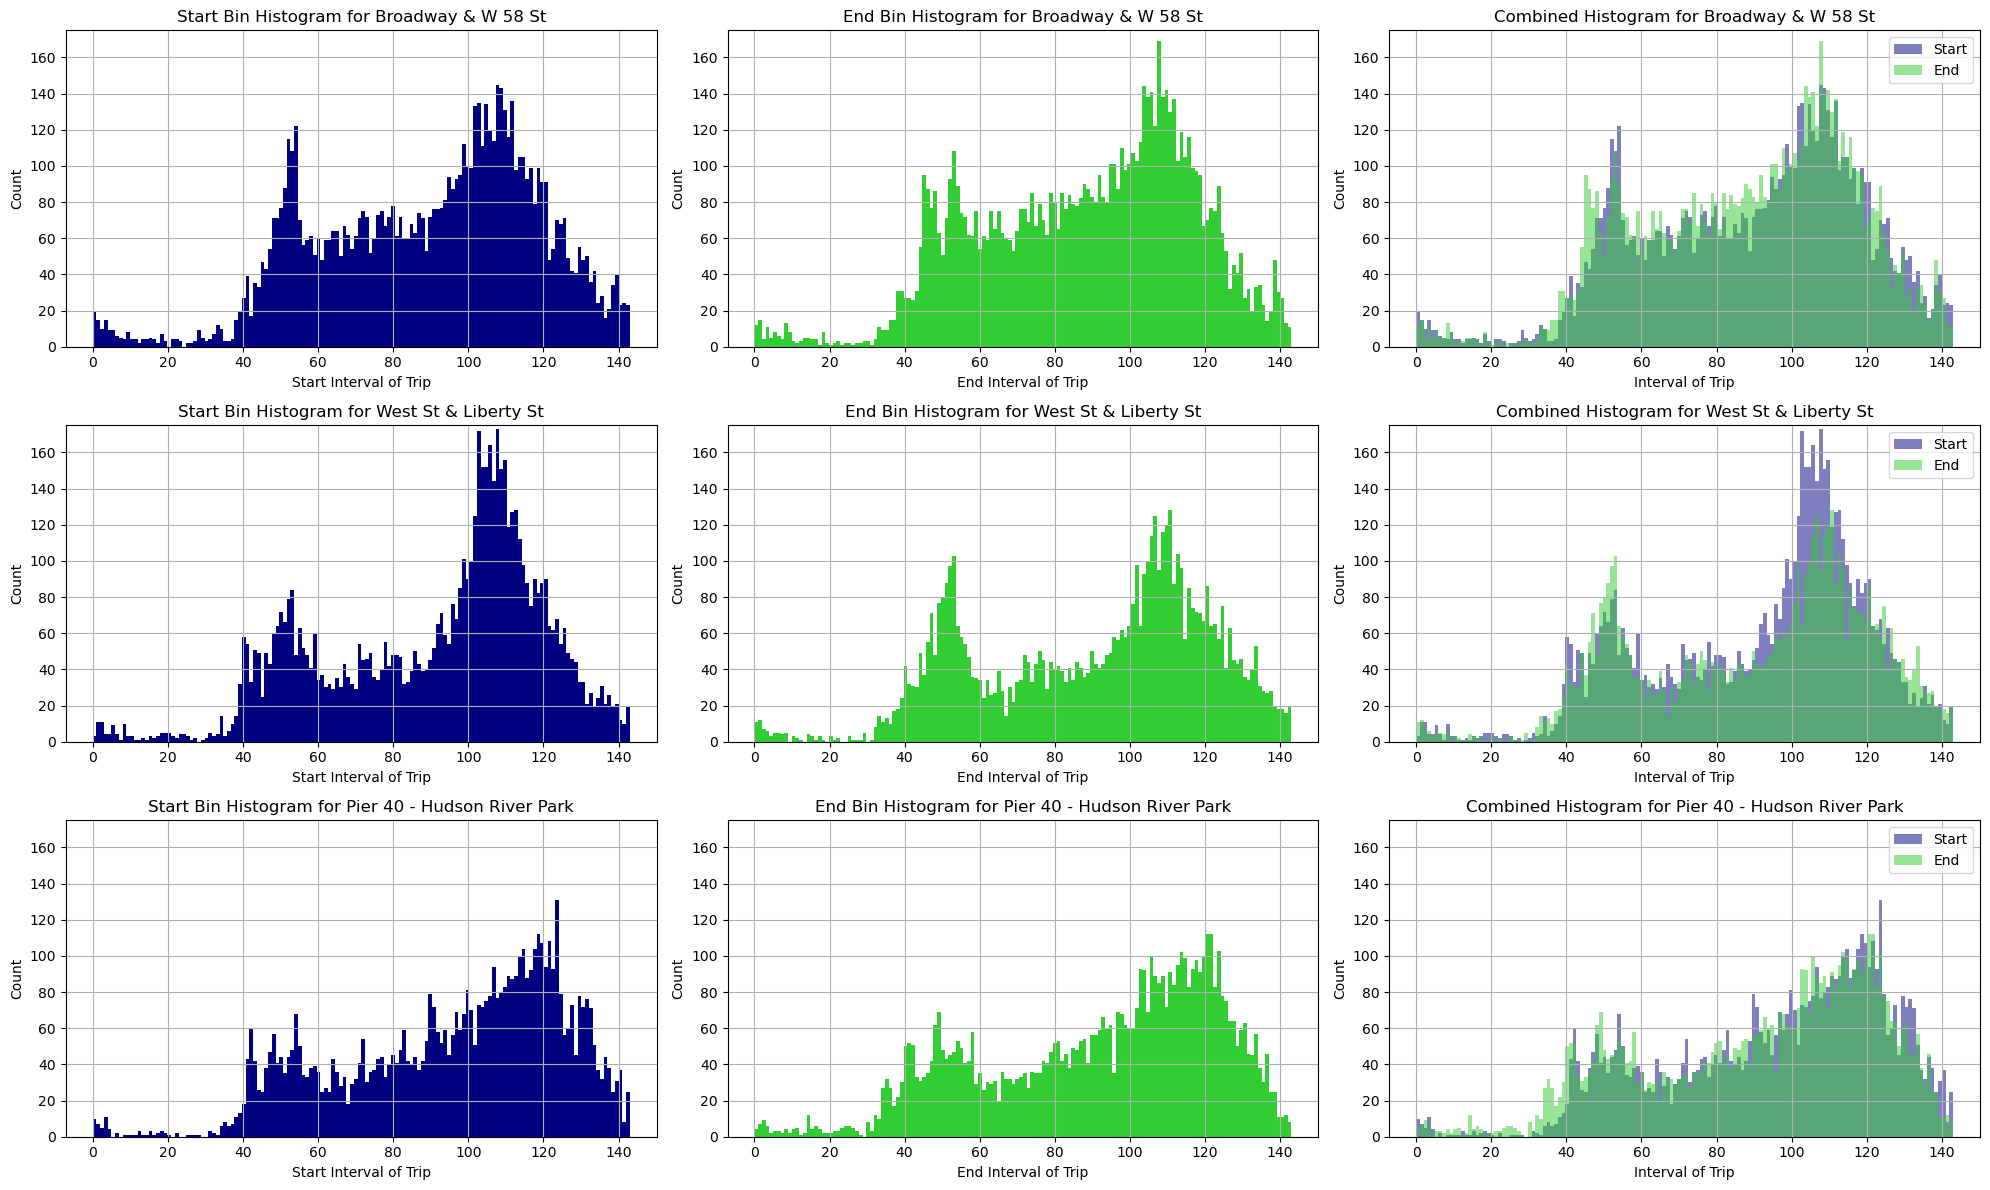

In [49]:
plt.figure(figsize=(20, 12)) 

for i, station_id in enumerate(station_ids):
    # Create masks for trips that start or end at the current station
    mask_st = df_stations['start_station_id'] == station_id
    mask_end = df_stations['end_station_id'] == station_id

    # Histogram for start bin (1st column)
    plt.subplot(3, 3, 3*i + 1)  # 3 rows, 3 columns, subplot index for start bin
    plt.hist(df_stations[mask_st].start_bin, bins=24*60//intervals, color='navy')
    plt.title(f"Start Bin Histogram for {station_map[station_id].get('station_name')}")
    plt.xlabel('Start Interval of Trip')
    plt.ylabel('Count')
    plt.ylim(0, 175)  # Set y-axis limits
    plt.grid()

    # Histogram for end bin (2nd column)
    plt.subplot(3, 3, 3*i + 2)  # 3 rows, 3 columns, subplot index for end bin
    plt.hist(df_stations[mask_end].end_bin, bins=24*60//intervals, color='limegreen')
    plt.title(f"End Bin Histogram for {station_map[station_id].get('station_name')}")
    plt.xlabel('End Interval of Trip')
    plt.ylabel('Count')
    plt.ylim(0, 175)  # Set y-axis limits
    plt.grid()

    # Combined histogram (3rd column)
    plt.subplot(3, 3, 3*i + 3)  # 3 rows, 3 columns, subplot index for combined histogram
    plt.hist(df_stations[mask_st].start_bin, bins=24*60//intervals, color='navy', alpha=0.5, label='Start')
    plt.hist(df_stations[mask_end].end_bin, bins=24*60//intervals, color='limegreen', alpha=0.5, label='End')
    plt.title(f"Combined Histogram for {station_map[station_id].get('station_name')}")
    plt.xlabel('Interval of Trip')
    plt.ylabel('Count')
    plt.ylim(0, 175)
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

**Analysis:**

The histograms provided above illustrate the distribution of trips for each starting and ending time slot, offering a clear view of the daily patterns in trip occurrences. These visuals aid in understanding the frequency and timing of trips from morning till night. As it was expected, the histograms for Broadway & W 58 St and West St & Liberty St show bimodal distributions for both starting and ending trips, indicating two peak times corresponding to rush hours. In contrast, Pier 40 - Hudson River Park has a more varied start time distribution but still shows a pronounced peak for ending trips. These patterns highlight the stations' activity rhythms and are essential for managing the bike-share system to meet commuter demand effectively.

## Morning and Evening time blocks

- Morning: 6:30am - 12:30pm (39 - 75 for 10 min intervals or 78 - 150 for 5 min intervals)
- Evening: 4:00pm - 10:00pm (96 - 132 for 10 min intervals or 192 - 264 for 5 min intervals)

We selected these times, as we felt they captured the majority of activity for that part of the day and logically fit with how people may interact with CitiBike throughout the day. For example, from 6:30am to 12:30pm, people are likely starting their day by going to work or doing some exploring around the city. In the evening time from 4:00pm to 10:00pm, many workers are likley making their way home and people will also likely begin some evening activities around the city.

In [51]:
# morning_start, morning_end = 78, 150
# evening_start, evening_end = 192, 264
morning_start, morning_end = 39, 75
evening_start, evening_end = 96, 132

mask_morning_st = (morning_start <= df_stations.start_bin) & (df_stations.start_bin <= morning_end) & (df_stations.start_station_id.isin(station_ids))
mask_morning_end = (morning_start <= df_stations.end_bin) & (df_stations.end_bin <= morning_end) & (df_stations.end_station_id.isin(station_ids))

mask_evening_st = (evening_start <= df_stations.start_bin) & (df_stations.start_bin <= evening_end) & (df_stations.start_station_id.isin(station_ids))
mask_evening_end = (evening_start <= df_stations.end_bin) & (df_stations.end_bin <= evening_end) & (df_stations.end_station_id.isin(station_ids))

df_stations_morn = df_stations[mask_morning_st | mask_morning_end]
df_stations_even = df_stations[mask_evening_st | mask_evening_end]

In [52]:
mask_1_st = df_stations.start_station_id == station_1_id
mask_1_end = df_stations.end_station_id == station_1_id
df_s1_m = df_stations_morn.loc[mask_1_st | mask_1_end, :]
df_s1_e = df_stations_even.loc[mask_1_st | mask_1_end, :]

In [53]:
print(f"Morning points: {len(df_s1_m)} ; Evening Points: {len(df_s1_e)}")

Morning points: 4500 ; Evening Points: 6684


In [54]:
mask_2_st = df_stations.start_station_id == station_2_id
mask_2_end = df_stations.end_station_id == station_2_id
df_s2_m = df_stations_morn.loc[mask_2_st | mask_2_end,:]
df_s2_e = df_stations_even.loc[mask_2_st | mask_2_end,:]

In [55]:
print(f"Morning points: {len(df_s2_m)} ; Evening Points: {len(df_s2_e)}")

Morning points: 3338 ; Evening Points: 6139


In [56]:
mask_3_st = df_stations.start_station_id == station_3_id
mask_3_end = df_stations.end_station_id == station_3_id
df_s3_m = df_stations_morn.loc[mask_3_st | mask_3_end, :]
df_s3_e = df_stations_even.loc[mask_3_st | mask_3_end, :]

In [57]:
print(f"Morning points: {len(df_s3_m)} ; Evening Points: {len(df_s3_e)}")

Morning points: 2756 ; Evening Points: 5826


**Analysis:**

It is obvious from the data that each of the chosen locations experiences a higher volume of trips during the evening hours. The pattern of more trips in the evening can be attributed to commuters using bikes to return home, people undertaking leisure activities or errands after work, and individuals incorporating cycling into their evening exercise routines. Favorable weather conditions in the evenings and extended daylight hours, especially in summer, also make it a preferred time for biking. Additionally, tourists are likely to use the service for sightseeing during these hours, further contributing to the increased usage.

## Build Transition Matrix

Here below, we wrote an algorithm for our transition matrix for the selected stations. First, we defined bins for morning and evening to help build transition matrix. Then, build a function 'get_transtion_matrix' to ..
Gather the transition matrix for each of our stations in both the morning and evening

In [58]:
morning_bins = range(morning_start, morning_end + 1)
evening_bins = range(evening_start, evening_end + 1)

In [59]:
def get_transition_matrix(df, station_id, bins):
    # Get capacity
    capacity = station_map[station_id]["dock_size"]
    
    mask_start_station = df.start_station_id == station_id
    mask_end_station = df.end_station_id == station_id
    mask_same_bin = df.start_bin == df.end_bin 
    
    # Column of +/- 1 if start or end at the staion
    df.loc[mask_start_station, 'ride_delta'] = -1
    df.loc[mask_end_station, 'ride_delta'] = 1
    
    # Put the actual bin for this station
    df.loc[:, "true_bin"] = df.loc[:, "start_bin"]
    df.loc[df.end_station_id == station_id, 'true_bin'] = df["end_bin"]
    
    # The ride is within the same dock and within the same bin (meaning no change)
    df.loc[mask_start_station & mask_end_station & mask_same_bin, 'ride_delta'] = 0
    
    # For all the rides that share the same start and end station and 
    # fall within different bins we are only saving the ride as if the ride ended up in that dock, 
    # and we are not considering the (same) ride that actually left the dock 
    
    df_missed_rides = df.loc[mask_start_station & mask_end_station & ~ mask_same_bin]
    # Need this to add the missing rides with correct columns for start that was missing
    df_missed_rides.loc[:, "true_bin"] = df_missed_rides.loc[:, "start_bin"]
    df_missed_rides.loc[:, 'ride_delta'] = -1
    
    # Add rows with same start end station and different bins
    df = pd.concat([df, df_missed_rides]).reset_index(drop=True
                                                     )
    # Add date column (day of month) so we can check number of transitions
    df.loc[:, "date"] = df["started_at"].dt.date
    df.loc[df.end_station_id == station_id, "date"] = df["ended_at"].dt.date
    
    # Sum up the ride_deltas within each bin on each day to get ride_delta for each day within each bin
    df_group = df.groupby(["date", "true_bin"]).ride_delta.sum().reset_index()
    
    # Make sure all bins for each day accounted for
    # If no rides occured in a bin then it should be logged as ride_delta of 0
    all_dates = df_group.date.unique()
    all_combinations =  pd.MultiIndex.from_product([all_dates, bins], names=['date', 'true_bin']
    ).to_frame(index=False)
    all_combinations['ride_delta'] = 0
    
    # Merge with all data bin combinations and set any missing combinations to 0
    df_merge = pd.merge(all_combinations, df_group, on=["date", "true_bin"], how="left").fillna(0)
    df_merge = df_merge.drop("ride_delta_x", axis=1)
    df_merge = df_merge.rename(columns={"ride_delta_y": "ride_delta"})
    
    # Count up the number of occurences of ride_delta to help create transition matrix
    df_counts = df_merge.groupby("ride_delta")['true_bin'].count().reset_index()
    
    # Create a dict to make for easy access to values for each ride_delta
    dict_counts = df_counts.set_index('ride_delta')['true_bin'].to_dict()
    
    # Create P, assuming that transitioning is independent of starting state
    # This means that we assume seeing that going from 0 to 1 is same as going from 5 to 6
    # After adding counts to each column, we sum by total counts for each row to ensure each row adds up to 1
    
    P = np.zeros((capacity+1, capacity+1))
    
    for start_state in range(capacity + 1):
        total_row = 0
        for end_state in range(capacity + 1):
            diff = end_state - start_state
            val = dict_counts.get(diff, 0)
            total_row += val
            P[start_state, end_state] = val
        P[start_state, :] /= total_row
    
    return P, df_counts

In [60]:
P_s1_m, d_s1_m = get_transition_matrix(df_s1_m, station_1_id, morning_bins)
P_s1_e, d_s1_e  = get_transition_matrix(df_s1_e, station_1_id, evening_bins)

In [61]:
P_s2_m, d_s2_m = get_transition_matrix(df_s2_m, station_2_id, morning_bins)
P_s2_e, d_s2_e = get_transition_matrix(df_s2_e, station_2_id, evening_bins)

In [62]:
P_s3_m, d_s3_m = get_transition_matrix(df_s3_m, station_3_id, morning_bins)
P_s3_e, d_s3_e = get_transition_matrix(df_s3_e, station_3_id, evening_bins)

### Plot of Delta Transition Probabilities
These plots are an indication of how frequently we saw absolute changes in the number of bikes within our discretized intervals.

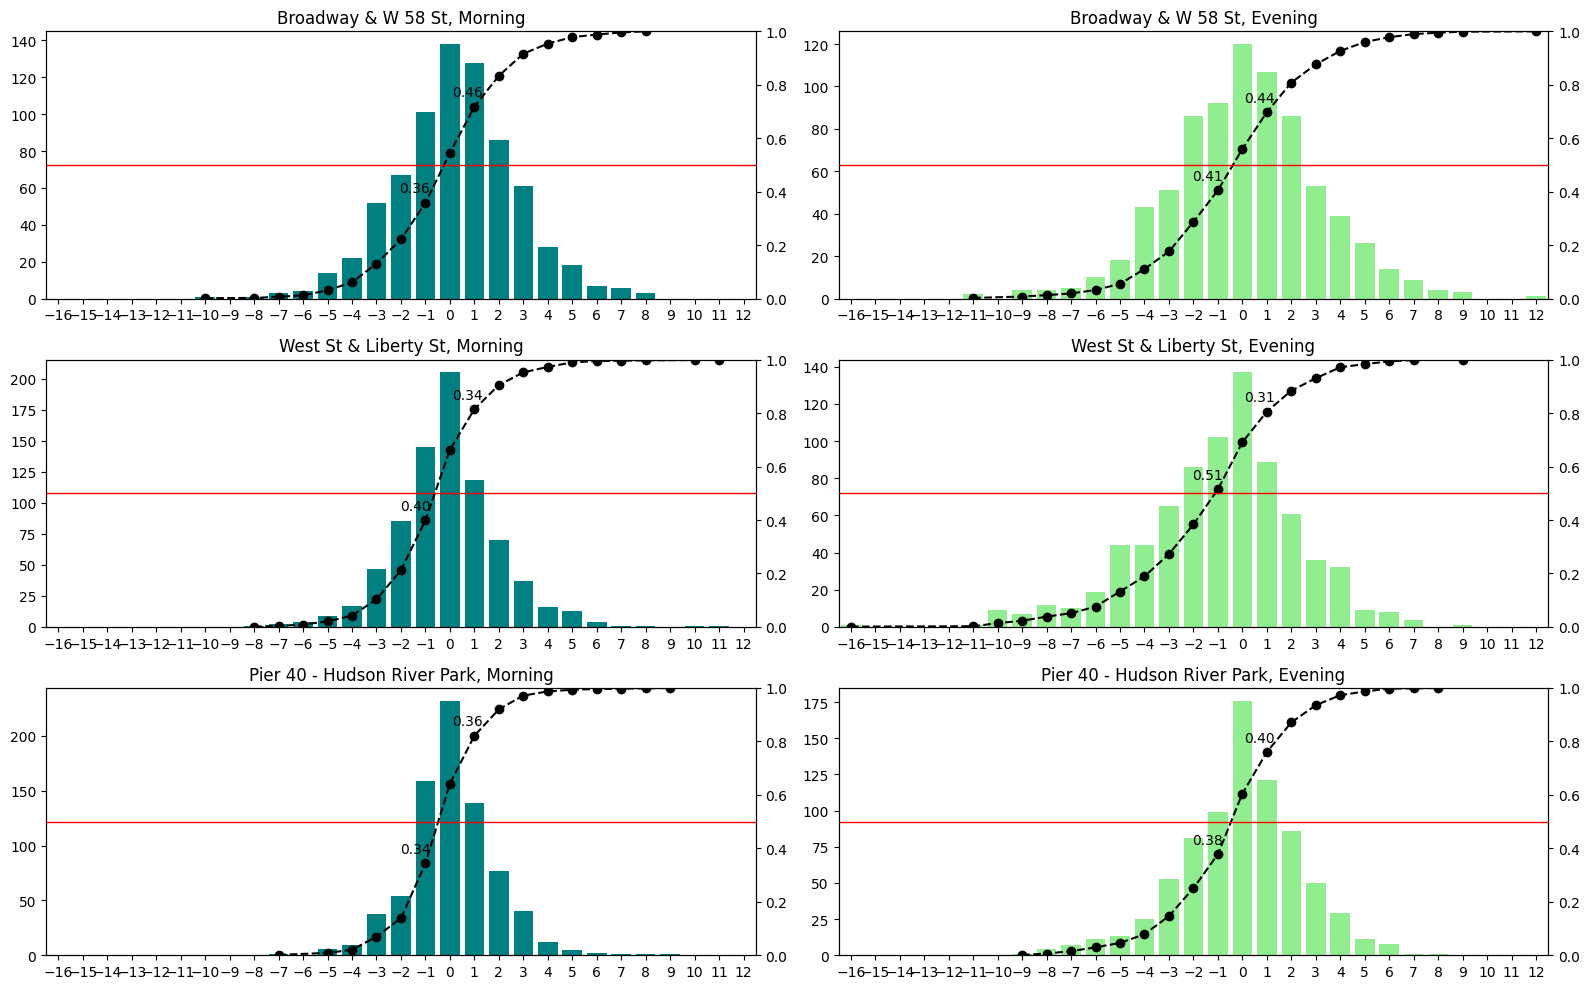

In [499]:
fig, axs = plt.subplots(3, 2, figsize=(16, 10), sharex=False)  # 3 rows, 2 columns

x_ticks = range(-16, 13)

# Function to plot the bars and the CDF line
def plot_station(ax, ride_delta, true_bin, title, color):
    ax.bar(ride_delta, true_bin, color=color)
    ax.set_title(title)
    
    # Calculate the CDF
    cdf = true_bin.cumsum() / true_bin.sum()
    # Plot the CDF line
    ax2 = ax.twinx()
    ax2.plot(ride_delta, cdf, color='black', linestyle='--', marker='o')
    ax2.set_ylim(0, 1) 

    # Add a horizontal line at y=0.5
    ax2.axhline(y=0.5, color='red', linestyle='-', linewidth=1)
    
    cdf_val_n1 = cdf[ride_delta == -1].iloc[0]
    ax2.annotate(f'{cdf_val_n1:.2f}', (-1, cdf_val_n1), textcoords="offset points", xytext=(-7.5,7.5), ha='center')
    cdf_val_0 = cdf[ride_delta == 0].iloc[0]
    cdf_val_p1 = cdf[ride_delta == 1].iloc[0]
    ax2.annotate(f'{1 - cdf_val_0:.2f}', (1, cdf_val_p1), textcoords="offset points", xytext=(-5,7.5), ha='center')
        

# Plot each stationary distribution and its corresponding CDF
plot_station(axs[0, 0], d_s1_m.ride_delta, d_s1_m.true_bin, "Broadway & W 58 St, Morning", 'teal')
plot_station(axs[0, 1], d_s1_e.ride_delta, d_s1_e.true_bin, "Broadway & W 58 St, Evening", 'lightgreen')
plot_station(axs[1, 0], d_s2_m.ride_delta, d_s2_m.true_bin, "West St & Liberty St, Morning", 'teal')
plot_station(axs[1, 1], d_s2_e.ride_delta, d_s2_e.true_bin, "West St & Liberty St, Evening", 'lightgreen')
plot_station(axs[2, 0], d_s3_m.ride_delta, d_s3_m.true_bin, "Pier 40 - Hudson River Park, Morning", 'teal')
plot_station(axs[2, 1], d_s3_e.ride_delta, d_s3_e.true_bin, "Pier 40 - Hudson River Park, Evening", 'lightgreen')

for i, ax in enumerate(axs.flat):
    ax.set_xlim(-16.5, 12.5) 
    ax.set_xticks(x_ticks)

# Adjust layout
plt.tight_layout()
plt.show()

As seen in the plots above, they tend to each look like a Normal distribution centered at 0, and some have slight tendencies to have more or less rides. The annotations indicate the proportion of transitions to values resutling in less bikes at the dock and more bikes in the dock. This will help us understand what to expect for the stationary distribution.

For the Broadway & 58th station, we see that the probability we jump to a positive or negative change is fairly similar, but that the top probaiblity events are more those which go to postive deltas and more likely tyo jump in that direction. Thus we expect to see skews tailing towards low values, but a more extreme skew with evening stationary distribution.

For West & Liberty station, in the morning there is a bit more fluctuation in the transitions observed and likely this will have a somewhat balanced stationary distribution, but since the probabilty to lose bikes is higher a skew tailing to higher values. In the evening time however, we see that there are much more trips starting here and thus leading to the docks being less full, a trend we expect to see in the stationary distribution with a much greater skew towards higher values.

For Pier 40, in the morning, it appears that although the second highest event is -1, in general there tends to be more bikes being added to the dock. In the evening we see this, but it is more clear that bikes are being added - although it is still quite balanced. We expect to see more balanced stationary distributions for this station, likely with some tails towards lower values.

### Plot of Transition Matrix

In [487]:
def display_P(P, station_id, tod):
    plt.figure(figsize=(26, 14))

    ax = sns.heatmap(P * 100, cmap=sns.color_palette("Blues", as_cmap=True), 
                annot=True, fmt=".1f",
                linewidths=0.5, cbar=False,
                annot_kws={"size": 6},
                mask=(P == 0)) # Masking zero values
    for t in ax.texts: t.set_text(t.get_text() + " %")
    plt.title(f'Transition Matrix of {station_map[station_id]["station_name"]} at {tod} time')
    plt.show()

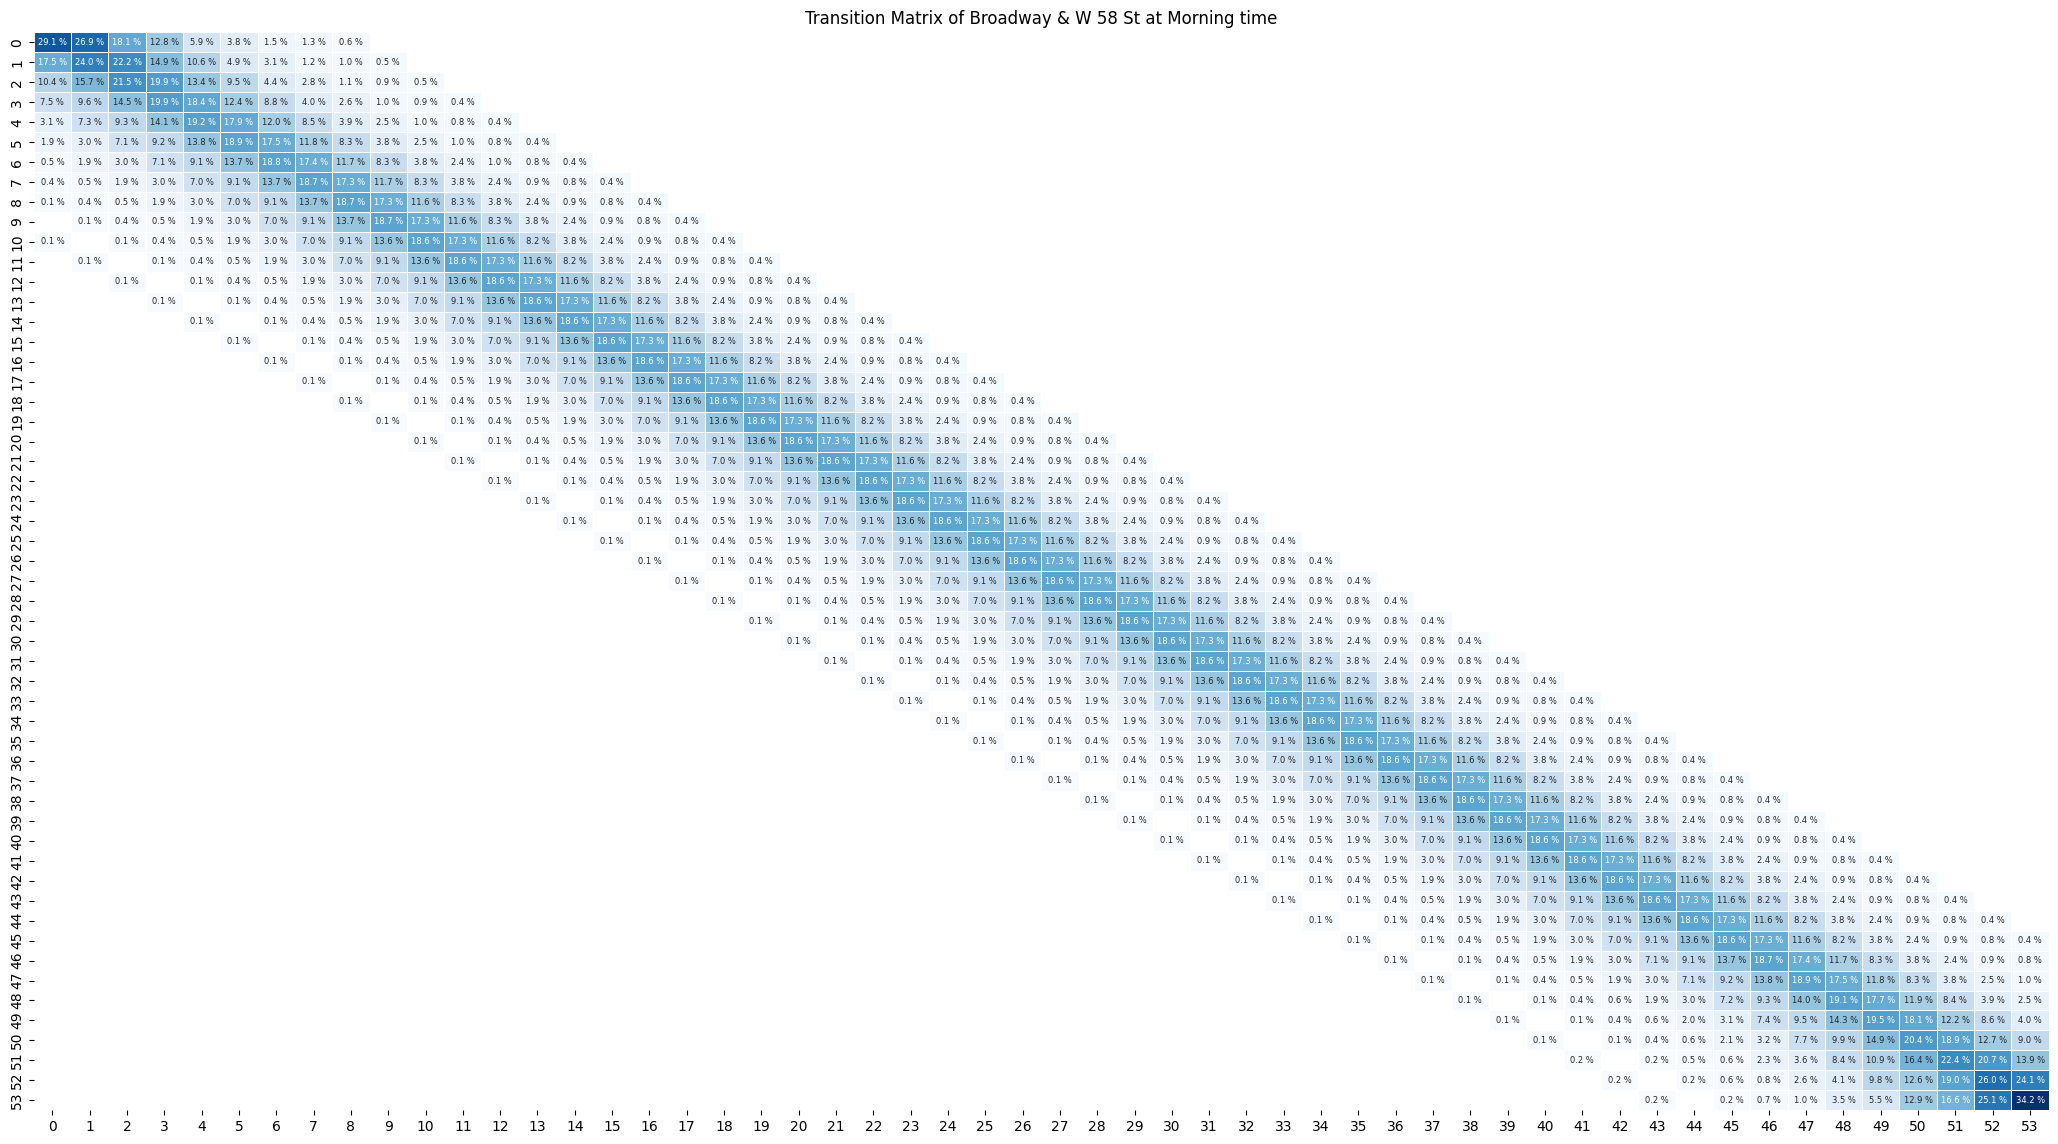

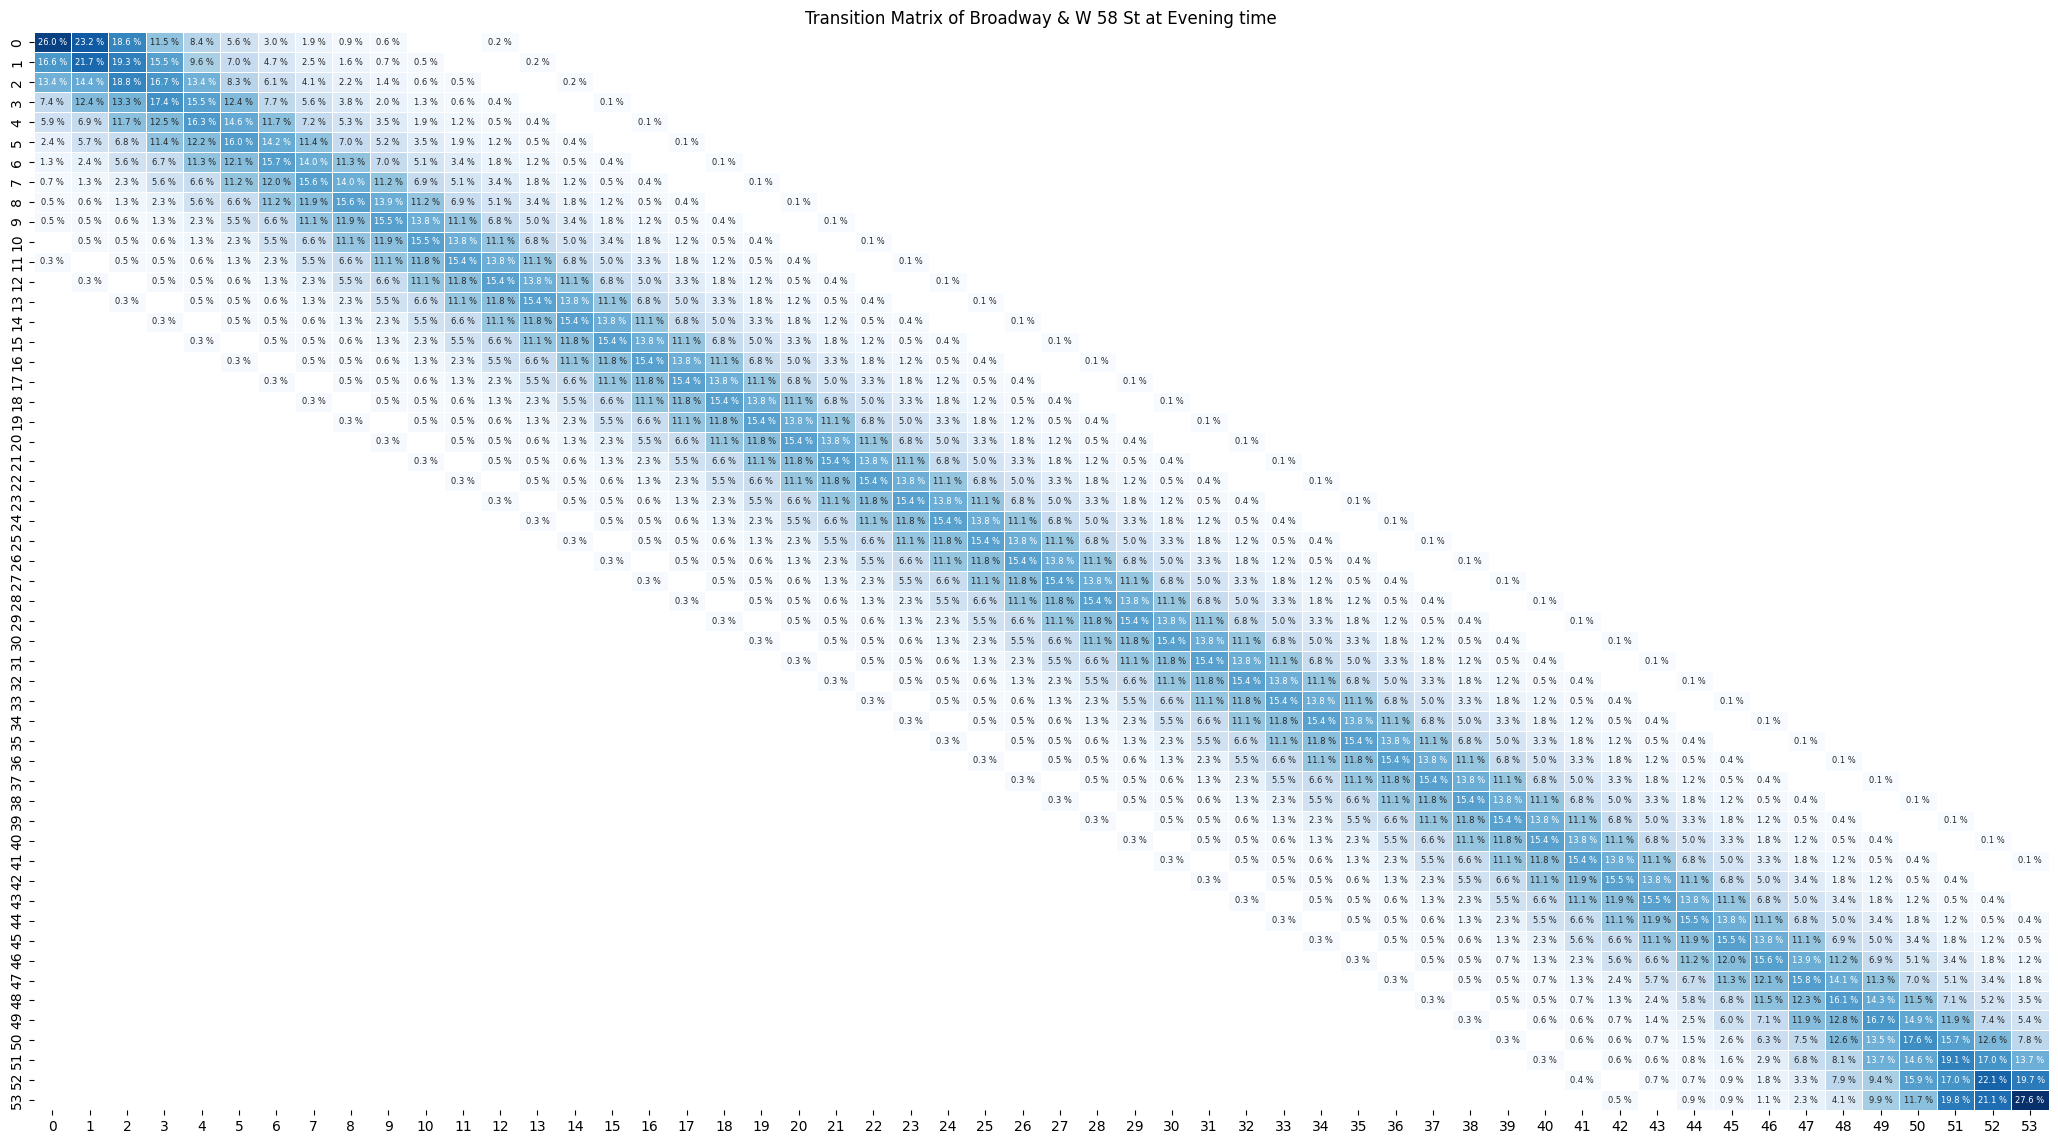

In [488]:
display_P(P_s1_m, station_1_id, "Morning")
display_P(P_s1_e, station_1_id, "Evening")

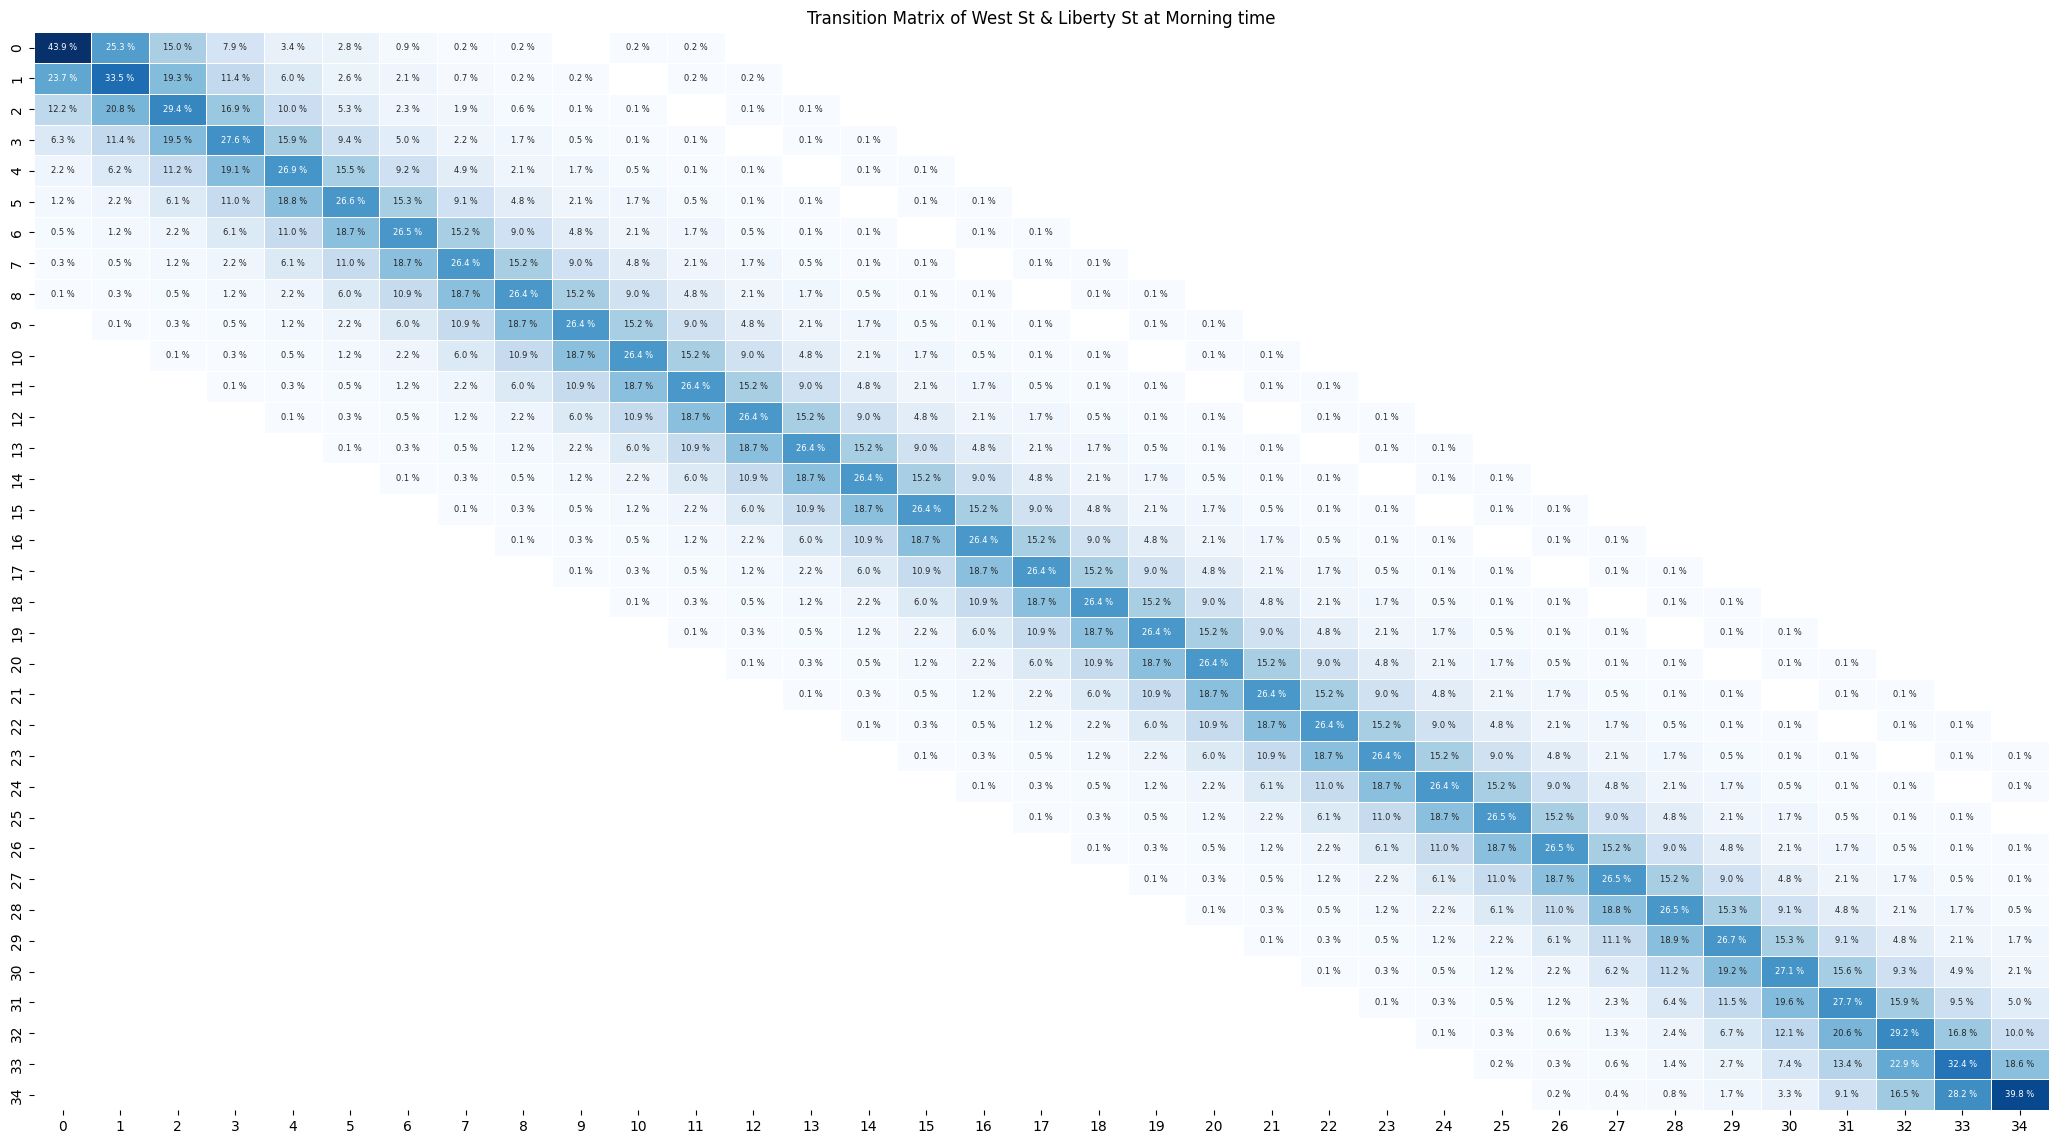

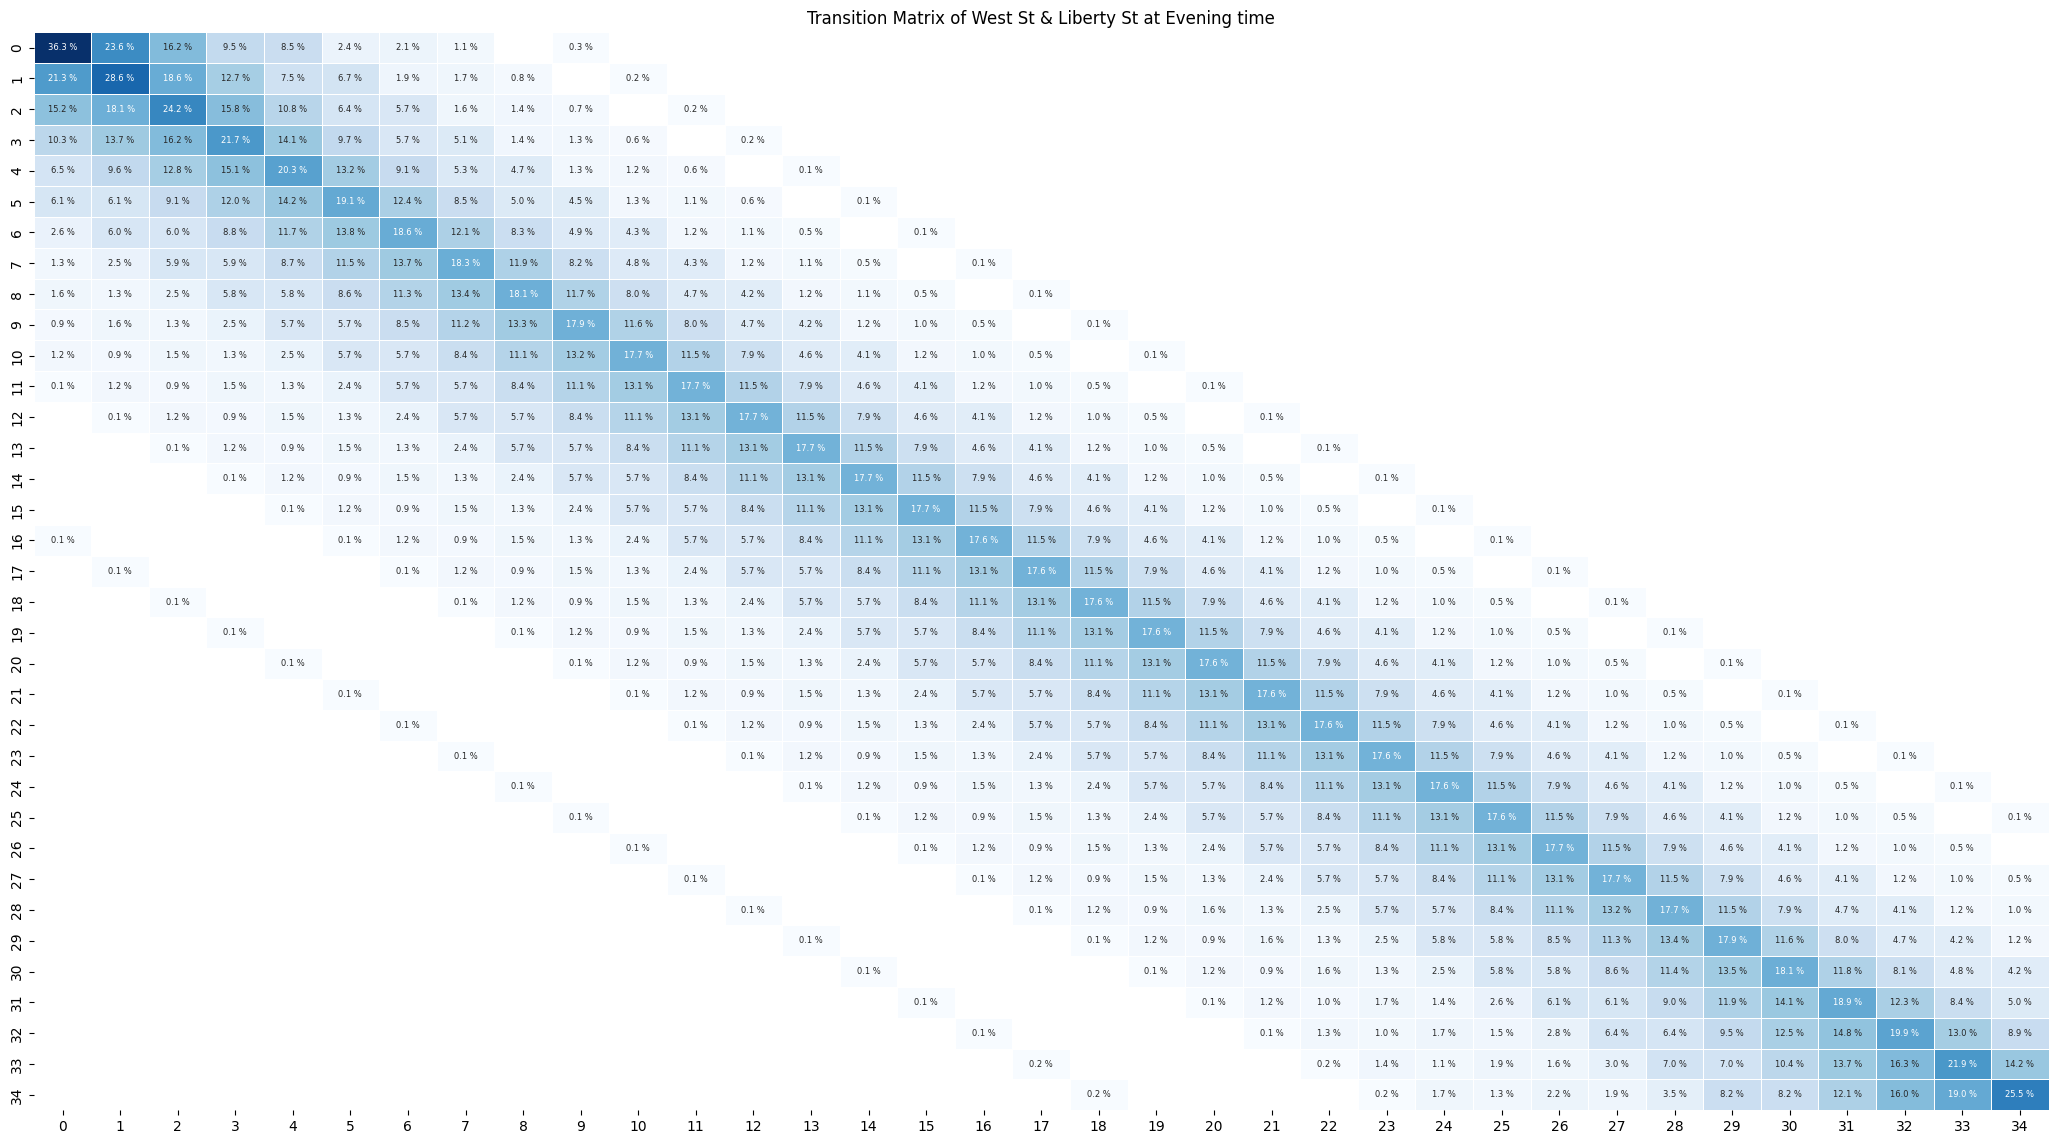

In [489]:
display_P(P_s2_m, station_2_id, "Morning")
display_P(P_s2_e, station_2_id, "Evening")

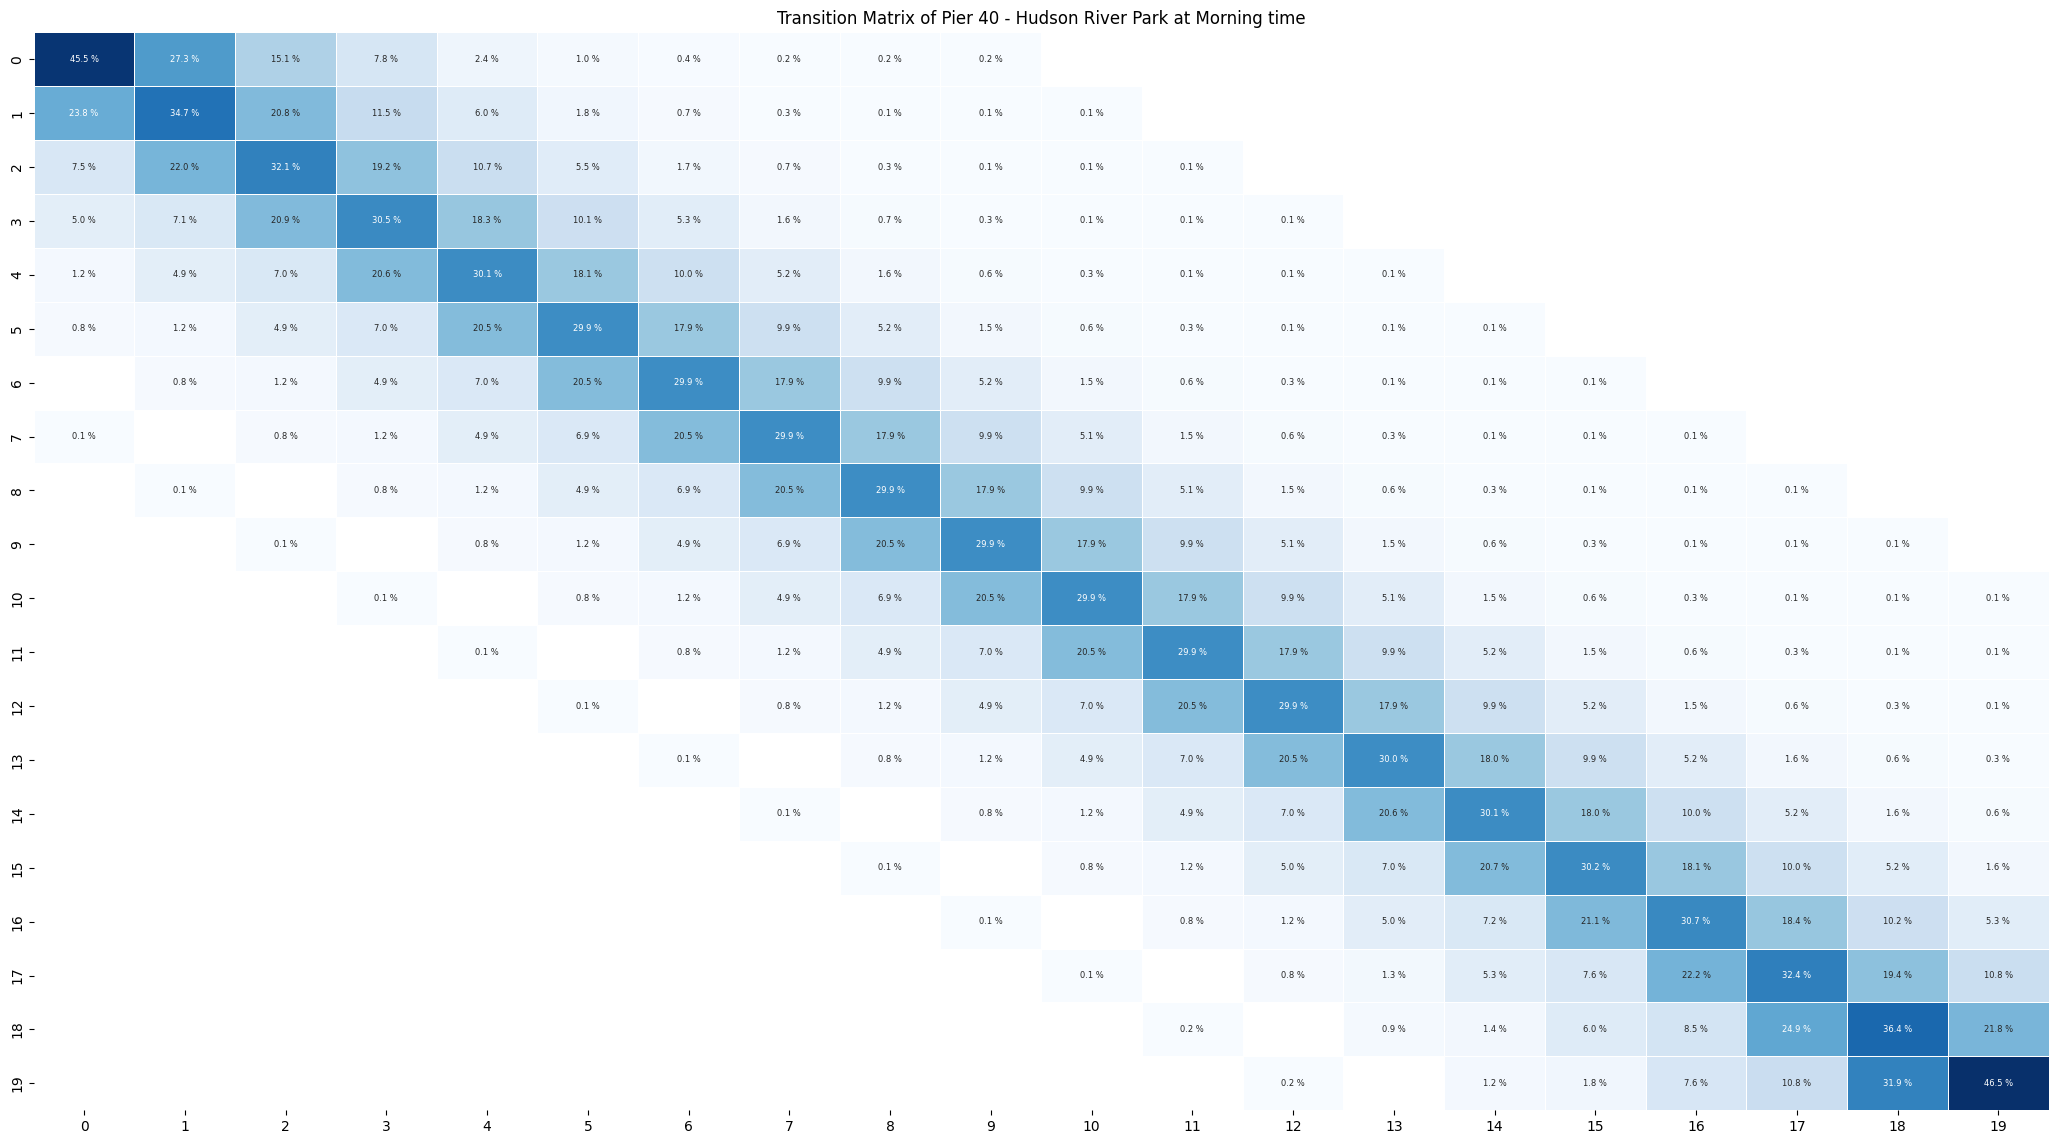

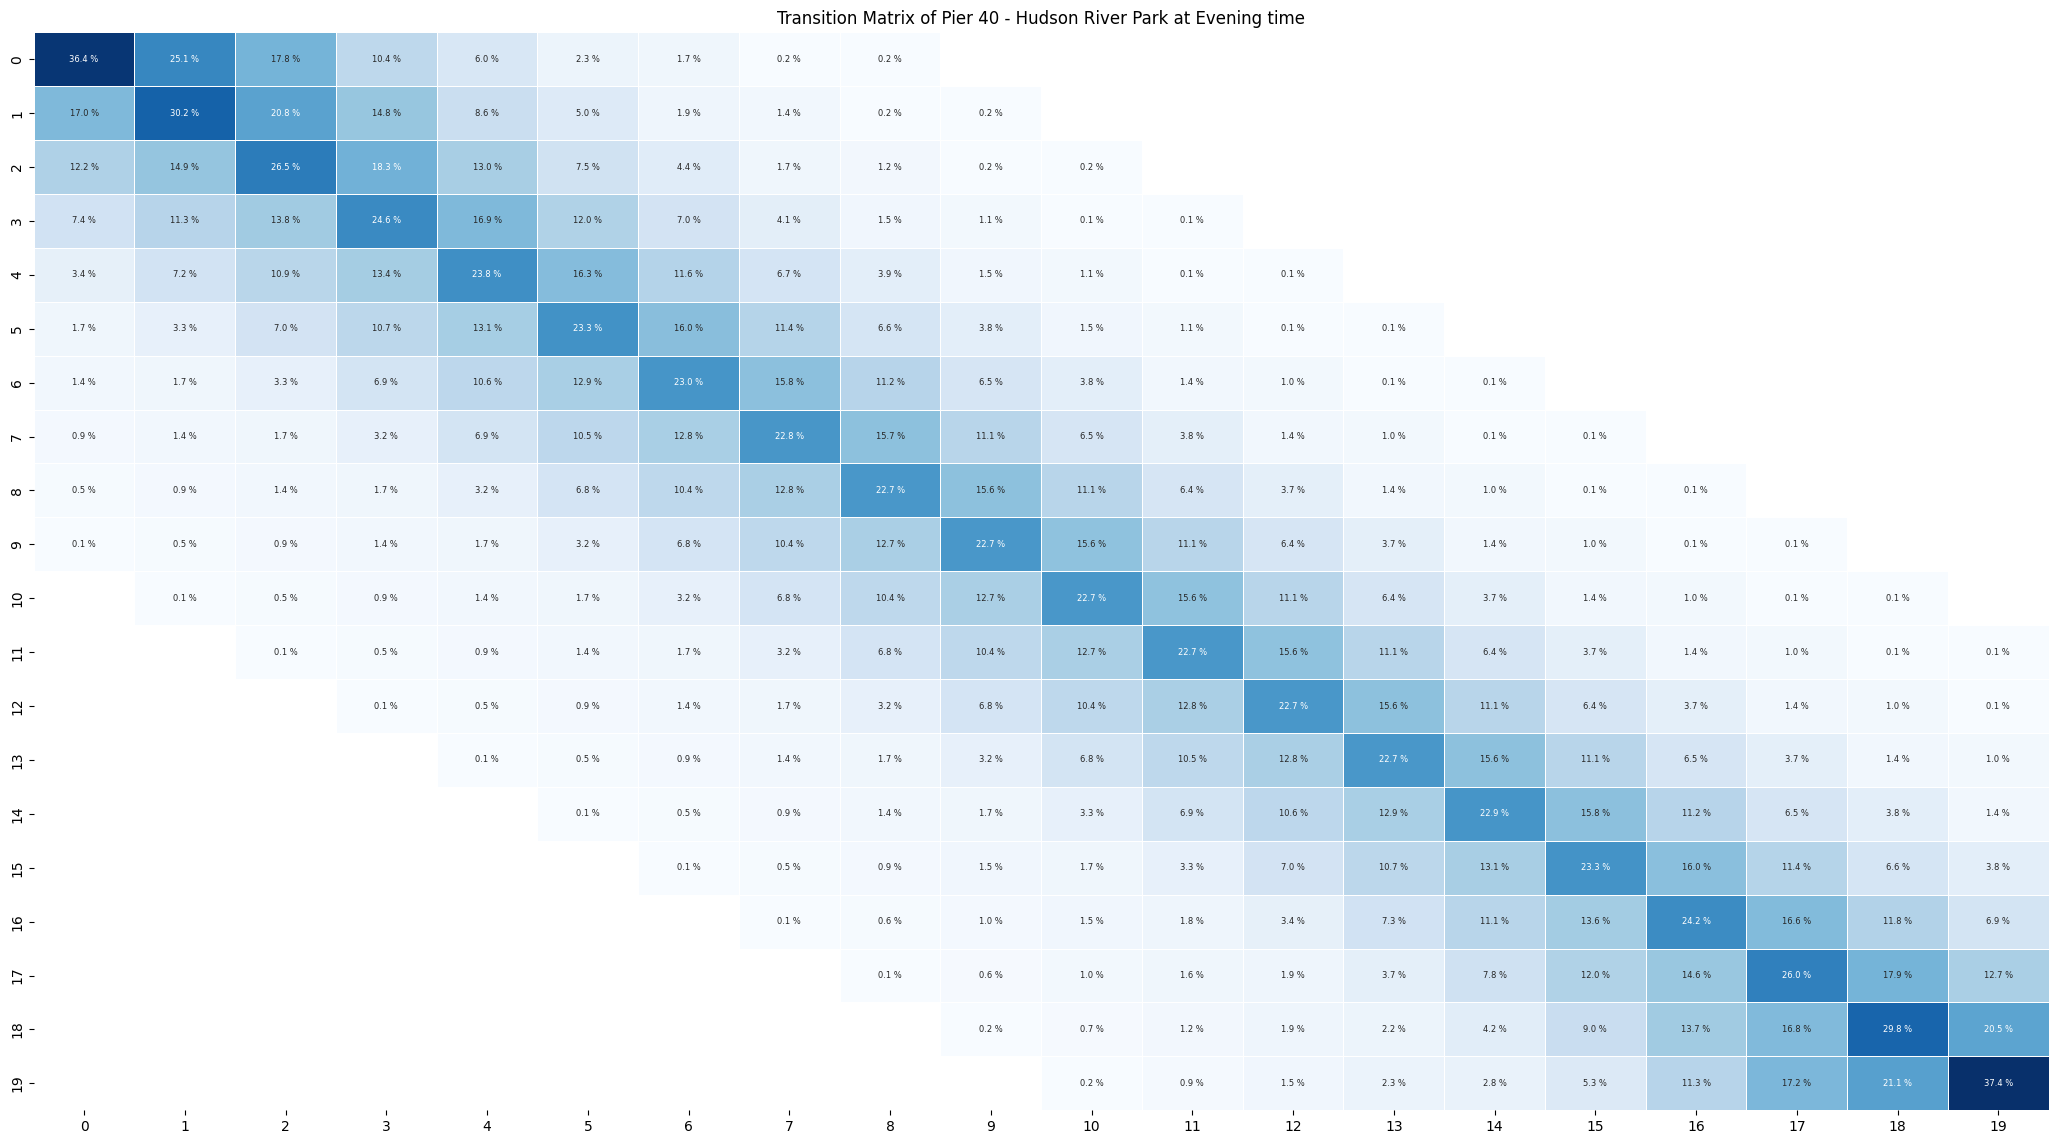

In [490]:
display_P(P_s3_m, station_3_id, "Morning")
display_P(P_s3_e, station_3_id, "Evening")

**Analysis:**

The transition matrices for all of our 3 stations show a high likelihood of the bikes remaining unchanged over short intervals, especially when few bikes are available. Probabilities decrease as the potential change in the number of bikes increases, indicating that significant fluctuations in bike availability are less common. There's a trend towards a higher probability of the station reaching near-full or full capacity, reflecting the return of bikes during the evening. 

## Stationary Distribution

In [491]:
def get_stationary_distribution(P):
    A = P.T
    A = A - np.eye(P.shape[0])
    A[-1, :] = 1
    
    b = np.zeros(P.shape[0])
    b[-1] = 1
    
    return np.linalg.solve(A, b)

In [492]:
pi_s1_m = get_stationary_distribution(P_s1_m)
pi_s1_e = get_stationary_distribution(P_s1_e)

In [493]:
pi_s2_m = get_stationary_distribution(P_s2_m)
pi_s2_e = get_stationary_distribution(P_s2_e)

In [494]:
pi_s3_m = get_stationary_distribution(P_s3_m)
pi_s3_e = get_stationary_distribution(P_s3_e)

### Visualizing the results of stationary distribution

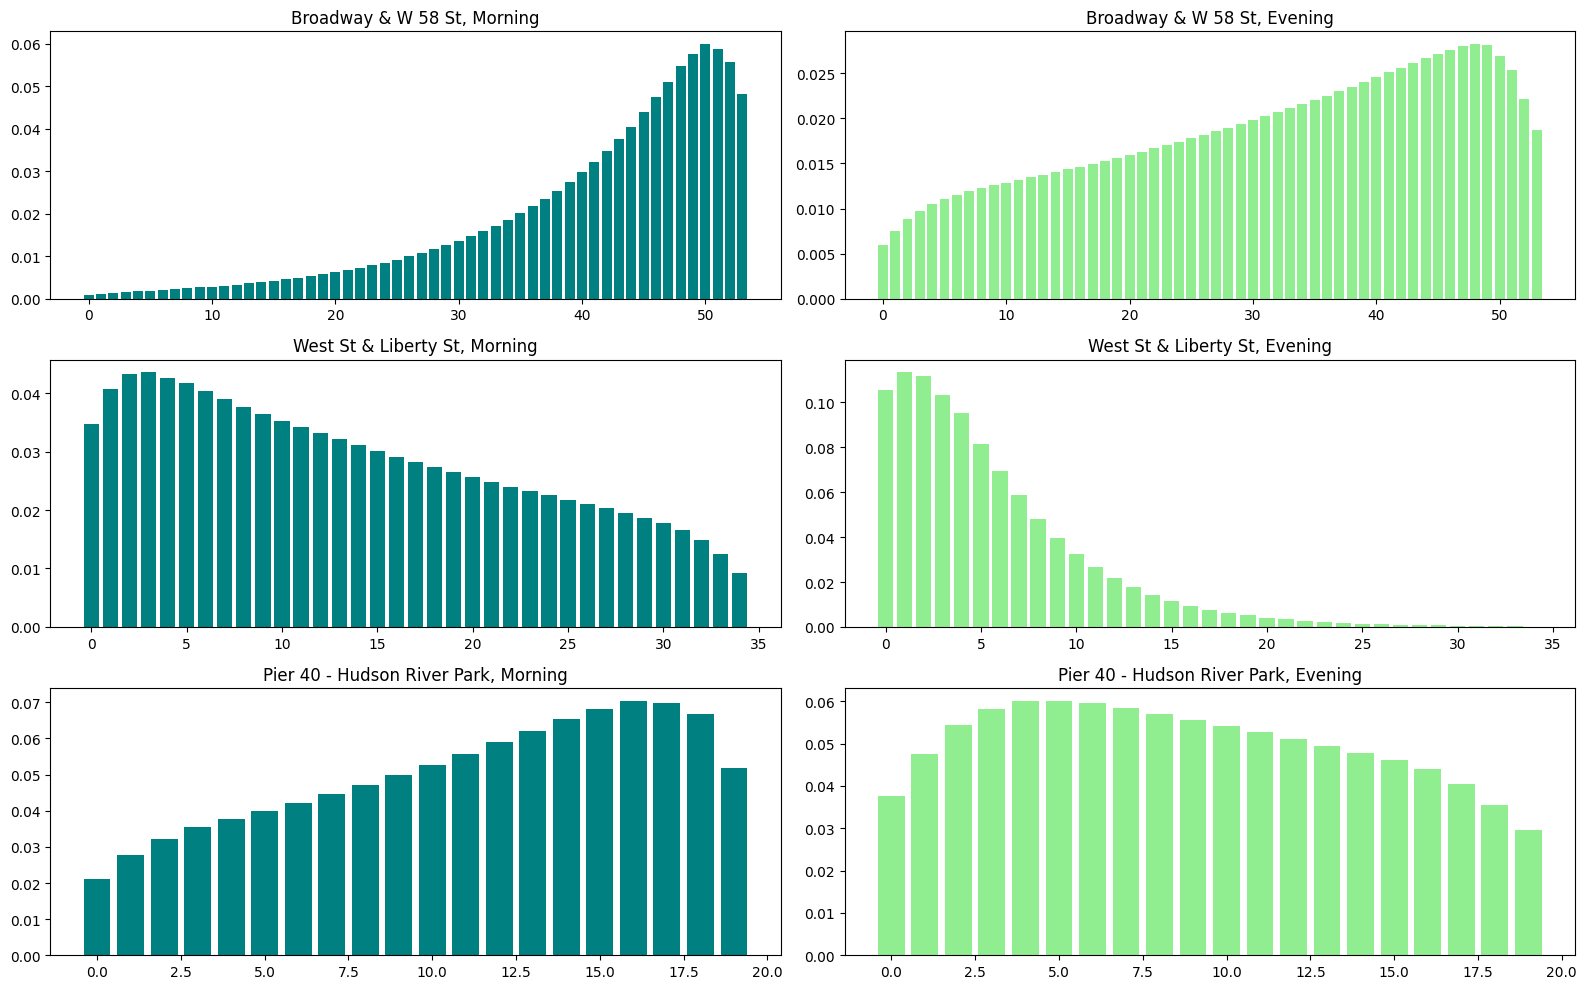

In [495]:
#Second option to visualize
fig, axs = plt.subplots(3, 2, figsize=(16, 10))  # 3 rows, 2 columns

# Plot each stationary distribution
axs[0, 0].bar(np.arange(len(pi_s1_m)), pi_s1_m, color = 'teal')
axs[0, 0].set_title("Broadway & W 58 St, Morning")

axs[0, 1].bar(np.arange(len(pi_s1_e)), pi_s1_e, color = 'lightgreen')
axs[0, 1].set_title("Broadway & W 58 St, Evening")

axs[1, 0].bar(np.arange(len(pi_s2_m)), pi_s2_m, color = 'teal')
axs[1, 0].set_title("West St & Liberty St, Morning")

axs[1, 1].bar(np.arange(len(pi_s2_e)), pi_s2_e, color = 'lightgreen')
axs[1, 1].set_title("West St & Liberty St, Evening")

axs[2, 0].bar(np.arange(len(pi_s3_m)), pi_s3_m, color = 'teal')
axs[2, 0].set_title("Pier 40 - Hudson River Park, Morning")

axs[2, 1].bar(np.arange(len(pi_s3_e)), pi_s3_e, color = 'lightgreen')
axs[2, 1].set_title("Pier 40 - Hudson River Park, Evening")

# Adjust layout
plt.tight_layout()
plt.show()

Broadway & 58th Morning: It is immediatly clear that the station is likely to be more full based on this stationary distribution. This makes sense with our observations of the transition matrix and ride deltas as we saw that shifting to adding mroe bikes was a higher probability than losing bikes. From a real world setting, likely what we are seeing is that many people are biking to this station, which is near Central Park and then getting off to walk around Central Park, or perhaps go to work at a location in the area. 

Broadway & 58th Evening: In the evening time there is a similar trend to the morning, however, it is not as significant. We see a much more balanced distribution. This is aligned with the analysis of the transition matrix as well, since we more similar transition probabilites to losing and gaining bikes at the station. The differences in morning and evening could be due to the fact less people are coming to visit Central Park as it gets darker out, and that gets balanced with people leaving Central Park to return home or continue their evenings.

West & Liberty Morning: This station in the morning is also fairly balanced with a skew tailing in the higher values. We saw that transition probabilites were also similar here but with a higher chance to have trips beginning at the station, hence the higher values for less bikes at the station. Before doing any analysis, in the morning we expected to see a somewhat opposite trend since there is a large workforce in the Financial District, but as shown here, there actually tends to be less people arriving and mroe people leaving. We could attribute this to more people actually living in this area and leaving for work, people using this CitiBike station as a starting point to bike around the Financial District and surrounding areas, people who visit the 9/11 Memorial or World Trade Center then leave to go exlore other areas of the city.

West & Liberty Evening: Shifting to the evening time, this is more in line with initial expectations. This also validates our analysis of transition probailities, where much more trips started at this station. The logic for this is clear: more people are going to be finishing work and leaving the station to go home and continue their evenings, there are likely still others who are visitng the Financial Distict and sites here, then takign this station as a way to contnue their visit in the city.

Pier 40 Morning: We see another balanced distribution here, with higher liklihood of seeing the station to be more full. This is expected from the analysis of transition matrix and ride deltas, where we observed similar likelihoods to transition to less and more bikes at the station. There was slightly higher likelihood to accumulate more bikes at the station and also a majority of the transtions with less bikes was only one less, meaning making the skew less balanced. What is likely happining in the morning time is that people arrive at the pier to walk around and explore, but also there are a lesser proportion of people leaving from this pier to go elsewhere or perhaps bike around the piers.

Pier 40 Evening: Similar to the morning distribution we see a balanced stationary distribution. However, we see an interesting trend, the rates to transition to a higher or lower number of bikes in the station was similar, with a slighter higher percent to increase bikes at the station. What we see here though is that we tend to observe the station to be less full - contrasting what we may have expected. Lets see if we can understand why. One thing to observe reviewing back to the transition probabilities is that there is the potential to lose 9 bikes in a given interval but only gain up to 6 - this could lead us to sway more to the lower end of bikes at the station. Reflecting on what is likley happening here in real life: we liklely see similar activity as with the morning time, but there are intervals where larger groups are leaving the station and we see typically more people leaving the piers to go elsewhere.

# THE END